# Bike Sharing Demand 

**
주어진 feature 기반으로 특정시점의 자전거 대여 수요를 예측하는 regression 문제임.  
Tensorflow(1.4+)로 학습을 통해 예측 모델을 만드는 방법은 네 가지 정도로 볼 수 있음.
**

1.가설함수(hypothesis), 손실함수(loss), 가중치(W), 바이어스(b) 등을 정의하고 neural network 를 직접 구현하는 방법
2.tensorflow.layers 같은 High level API 를 사용하여 neural network 를 구현하는 방법  
3.tensorflow.estimators 같은 High level API를 사용하여 neural network 를 구현하는 방법  
4.tensorflow.keras or Keras 같은 High level API를 사용하여 neural network 를 구현하는 방법  

여기서는 두번째, tensorflow.layers 같은 High level API를 사용하여 multi-layer neural network 를 구현한다.

확인 할 내용

- 입력 feature 들에 대한 전처리, 사용할 feature 선택에 따른 차이.
- 가중치 초기화를 random 으로 했을 경우, Xavier/He initializer 를 사용했을 경우 차이.
- 활성화 함수(sigmoid/tanh/relu) 사용에 따른 차이.
- Layer 수, Layer 별 neuron 수에 따른 차이.
- Optimizer 사용에 따른 차이 (GradientDescent, Adam 등)

https://www.kaggle.com/c/bike-sharing-demand

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Load Dataset

In [2]:
# parse_dates : 'datetime' 컬럼을 python date type 으로 처리하기 위해
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])

print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Explore

In [3]:
# 차트를 jupyter notebook에 출력해서 보기 위한 명령어
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

### Explore datetime

In [4]:
# datatime 을 python date type 으로 load 했기 때문에 '.dt' 속성을 이용해서 년/월/일/시/분/초/요일 등의 정보에 접근 가능함
# datatime 으로 부터 년/월/일/시/분/초 컬럼 추가
train["datetime-year"] = train["datetime"].dt.year
train["datetime-month"] = train["datetime"].dt.month
train["datetime-day"] = train["datetime"].dt.day
train["datetime-hour"] = train["datetime"].dt.hour
train["datetime-minute"] = train["datetime"].dt.minute
train["datetime-second"] = train["datetime"].dt.second

print(train.shape)
train[["datetime", "datetime-year", "datetime-month", "datetime-day", "datetime-hour", "datetime-minute", "datetime-second"]].head()

(10886, 18)


,datetime,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second
0,2011-01-01 00:00:00,2011,1,1,0,0,0
1,2011-01-01 01:00:00,2011,1,1,1,0,0
2,2011-01-01 02:00:00,2011,1,1,2,0,0
3,2011-01-01 03:00:00,2011,1,1,3,0,0
4,2011-01-01 04:00:00,2011,1,1,4,0,0


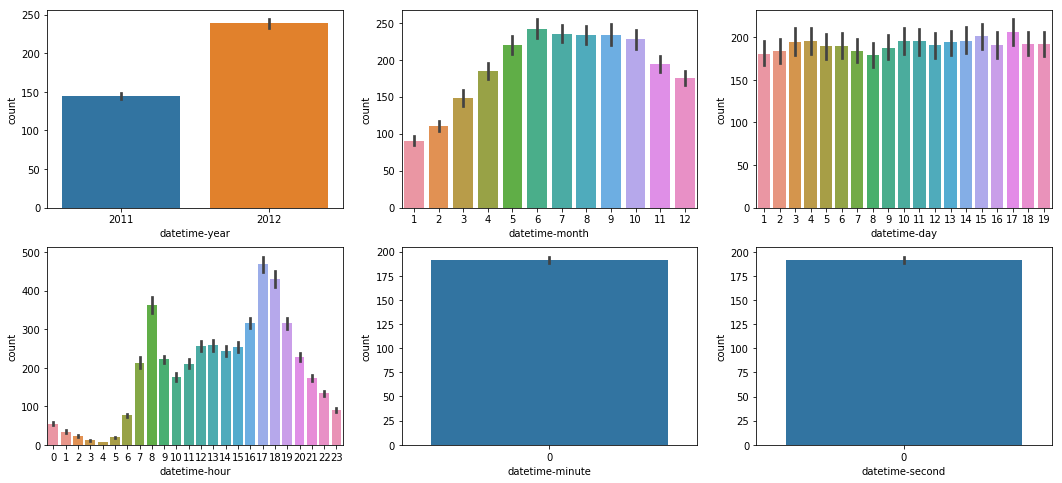

In [5]:
# 2 X 3 subplot 선언
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
# subplot size 선언
figure.set_size_inches(18, 8)
# time 관련 feature 들과 대여 수(count) 관계를 barplot 을 이용해 확인
sns.barplot(data=train, x="datetime-year", y="count", ax=ax1)
sns.barplot(data=train, x="datetime-month", y="count", ax=ax2)
sns.barplot(data=train, x="datetime-day", y="count", ax=ax3)
sns.barplot(data=train, x="datetime-hour", y="count", ax=ax4)
sns.barplot(data=train, x="datetime-minute", y="count", ax=ax5)
sns.barplot(data=train, x="datetime-second", y="count", ax=ax6)

** Lesson Learned **
  * **datetime-minute**와 **datetime-second**는 현재 기록되고 있지 않다. 그러므로 사용할 필요가 없다.
  * train.csv와 test.csv는 **datetime-day**를 기준으로 나뉘어져 있다. 그러므로 **datetime-day**를 feature로 사용해서는 안 된다.

### Explore hour - workingday

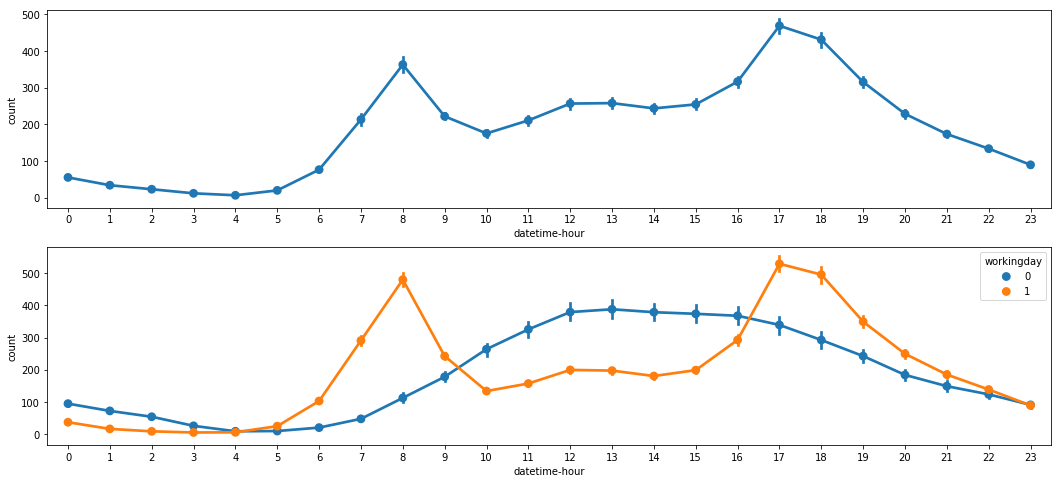

In [6]:
# 2 X 1 subplot 선언
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18, 8)

# 시간과 대여 수(count)의 관계를 pointplot 을 이용해 확인
sns.pointplot(data=train, x="datetime-hour", y="count", ax=ax1)
# hue="workingday" 를 추가해서 주중 시간대와, 주말 시간대별 대여수 관계를 확인
sns.pointplot(data=train, x="datetime-hour", y="count", hue="workingday", ax=ax2)

** Lesson Learned **
  * 주중(workingday==1)에는 출근 시간과 퇴근 시간에 자전거를 많이 대여한다.
  * 주말(workingday==0)에는 오후 시간에 자전거를 많이 대여한다.
  * 주중(월,화,수,목,금)이 주말(토,일)보다 많기 때문에, 두 개를 나눠서 보지 않으면 주말의 특성을 파악할 수 없다.

### Explore hour - dayofweek

In [7]:
# 요일(dayofweek) 컬럼 추가 (0 = monday, ~ 6 = sunday) 
train["datetime-dayofweek"] = train["datetime"].dt.dayofweek

print(train.shape)
train[["datetime", "datetime-dayofweek"]].head()

(10886, 19)


,datetime,datetime-dayofweek
0,2011-01-01 00:00:00,5
1,2011-01-01 01:00:00,5
2,2011-01-01 02:00:00,5
3,2011-01-01 03:00:00,5
4,2011-01-01 04:00:00,5


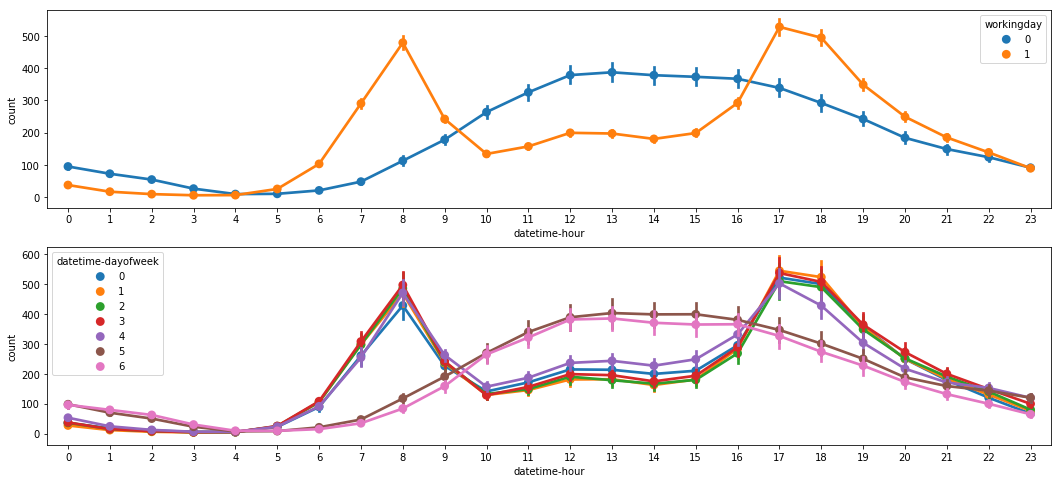

In [8]:
# 2 X 1 subplot 선언
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18, 8)

# 주중/주말 시간대별 대여수 차이
sns.pointplot(data=train, x="datetime-hour", y="count", hue="workingday", ax=ax1)
# 요일 시간대별 대여수 차이
sns.pointplot(data=train, x="datetime-hour", y="count", hue="datetime-dayofweek", ax=ax2)

** Lesson Learned **
  * 금요일(workingday==4)는 주중이지만, 아주 약간 주말의 특성을 반영하고 있다.
  * 비슷하게 월요일(workingday==0)도 아주 약간 주말의 특성을 반영하고 있다.
  * 사람들이 휴가를 월요일과 금요일에 사용하기 때문이라고 추측할 수 있다.

### Concatenate year and month

In [9]:
# datetime 을 받아서 '년-월' 값을 만들어 주는 함수 정의
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)
# 년-월 컬럼 추가 (년-월 별 대여량 차이 확인 하기 위해서)
train["datetime-year_month"] = train["datetime"].apply(concatenate_year_month)

print(train.shape)
train[["datetime", "datetime-year_month"]].head()

(10886, 20)


,datetime,datetime-year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


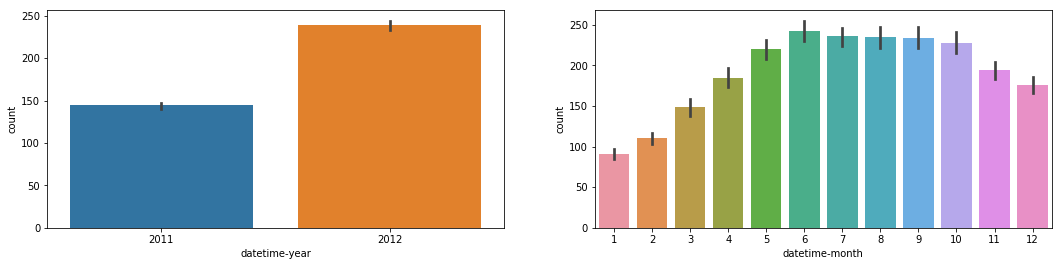

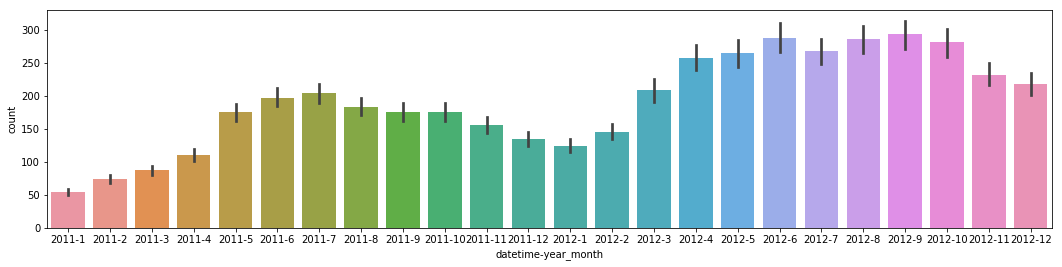

In [10]:
# 1 X 1 subplot 선언
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 4)
# 연도별 대여수 차이 확인
sns.barplot(data=train, x="datetime-year", y="count", ax=ax1)
# 월별 대여수 차이 확인
sns.barplot(data=train, x="datetime-month", y="count", ax=ax2)

# 하나짜리 subplot 선언 (차트 하나를 원하는 사이즈로 출력하고 싶을 때 사용하는 Tip)
figure, ax3 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)
# 위에서 새로 추가한 년-월 별 대여수 차이 확인
sns.barplot(data=train, x="datetime-year_month", y="count", ax=ax3)

** Lesson Learned **
  * 2011년 12월과 2012년 1월의 자전거 대여량을 비슷하지만, 두 개를 따로 놓고 보면 이를 알 수 없다.
  * 2011년에는 8월부터 대여량이 감소하고, 2012년에는 7월부터 대여량이 감소한다. 마찬가지로 따로 놓고 보면 이를 알 수 없다.

## Reload Dataset

In [2]:
# 전처리 하기위해 train 원본 데이터를 다시 load
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])

print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# test 데이터도 전처리를 같이 해야 하기 때문에 함께 load
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])

print(test.shape)
test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## Preprocessing

### Parse datetime

In [4]:
# train 데이터에 년/월/일/시간/요일 컬럼 추가
train["datetime-year"] = train["datetime"].dt.year
train["datetime-month"] = train["datetime"].dt.month
train["datetime-day"] = train["datetime"].dt.day
train["datetime-hour"] = train["datetime"].dt.hour
train["datetime-dayofweek"] = train["datetime"].dt.dayofweek

print(train.shape)
train[["datetime", "datetime-year", "datetime-month", "datetime-day", "datetime-hour", "datetime-dayofweek"]].head()

(10886, 17)


,datetime,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-dayofweek
0,2011-01-01 00:00:00,2011,1,1,0,5
1,2011-01-01 01:00:00,2011,1,1,1,5
2,2011-01-01 02:00:00,2011,1,1,2,5
3,2011-01-01 03:00:00,2011,1,1,3,5
4,2011-01-01 04:00:00,2011,1,1,4,5


In [5]:
# test 데이터에 년/월/일/시간/요일 컬럼 추가
test["datetime-year"] = test["datetime"].dt.year
test["datetime-month"] = test["datetime"].dt.month
test["datetime-day"] = test["datetime"].dt.day
test["datetime-hour"] = test["datetime"].dt.hour
test["datetime-dayofweek"] = test["datetime"].dt.dayofweek

print(test.shape)
test[["datetime", "datetime-year", "datetime-month", "datetime-day", "datetime-hour", "datetime-dayofweek"]].head()

(6493, 14)


,datetime,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-dayofweek
0,2011-01-20 00:00:00,2011,1,20,0,3
1,2011-01-20 01:00:00,2011,1,20,1,3
2,2011-01-20 02:00:00,2011,1,20,2,3
3,2011-01-20 03:00:00,2011,1,20,3,3
4,2011-01-20 04:00:00,2011,1,20,4,3


### Data for train

### Select features for Training

**
<span style="color:red">
One-hot encoding 하기전에는 아무리 해도 좋은 결과가 안나옴 (loss 수렴이 잘 안됨)  
One-hot encoding 을 통해 feature를 늘린 후 성능이 크게 개선 됨
</span>
**

In [6]:
# DataFrame.get_dummies() 를 사용해서 한번에 one-hot encoding 하기 위해 
# neumeric type을 string type 으로 수정
train['season'] = train['season'].astype(str)
train['weather'] = train['weather'].astype(str)
train['datetime-dayofweek'] = train['datetime-dayofweek'].astype(str)
train['datetime-hour'] = train['datetime-hour'].astype(str)

In [7]:
# DataFrame.get_dummies() 를 사용해서 한번에 one-hot encoding 하기 위해 
# neumeric type을 string type 으로 수정
test['season'] = test['season'].astype(str)
test['weather'] = test['weather'].astype(str)
test['datetime-dayofweek'] = test['datetime-dayofweek'].astype(str)
test['datetime-hour'] = test['datetime-hour'].astype(str)

In [8]:
#train 시킬 feature 선언
feature_names = ["season", "holiday", "workingday", "weather",
                 "atemp", "humidity", "datetime-year", 
                 "datetime-hour", "datetime-dayofweek"]

In [9]:
# train 시킬 데이터셋(feature) 준비 : X
# One-hot encoding (neumeric type 이 아닌 컬럼들은 모두 encoding 됨)
X = pd.get_dummies(train[feature_names])

print(X.shape)
X.head()

(10886, 44)


,holiday,workingday,atemp,humidity,datetime-year,season_1,season_2,season_3,season_4,weather_1,...,datetime-hour_7,datetime-hour_8,datetime-hour_9,datetime-dayofweek_0,datetime-dayofweek_1,datetime-dayofweek_2,datetime-dayofweek_3,datetime-dayofweek_4,datetime-dayofweek_5,datetime-dayofweek_6
0,0,0,14.395,81,2011,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,13.635,80,2011,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0,0,13.635,80,2011,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0,0,14.395,75,2011,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,0,14.395,75,2011,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [10]:
label_name = "count"
# loss 를 RMSLE (Root Mean Square Log Error) 로 측정하기 위해 
# label (actual value) 값을 변환
y = np.log(train[label_name]+1)

y.head(5)

0    2.833213
1    3.713572
2    3.496508
3    2.639057
4    0.693147
Name: count, dtype: float64

### Splitting train, test(evaluate) data set

In [11]:
# train 데이터 검증을 위한 test 데이터 준비
# train 데이터에서 일부 검증용으로 test 셋 분리
# 데이터 건수가 많지 않기 때문에 test 셋을 줄이고 train 셋을 늘리는 것이 좋을것 같음
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size = 0.20, random_state = 0)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(8708, 44) (2178, 44) (8708,) (2178,)


### Kaggle submit data set

In [12]:
# 예측(predict) 할 test 데이터셋 준비 : X_test
X_submit = pd.get_dummies(test[feature_names])

print(X_submit.shape)
X_submit.head()

(6493, 44)


,holiday,workingday,atemp,humidity,datetime-year,season_1,season_2,season_3,season_4,weather_1,...,datetime-hour_7,datetime-hour_8,datetime-hour_9,datetime-dayofweek_0,datetime-dayofweek_1,datetime-dayofweek_2,datetime-dayofweek_3,datetime-dayofweek_4,datetime-dayofweek_5,datetime-dayofweek_6
0,0,1,11.365,56,2011,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,1,13.635,56,2011,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,1,13.635,56,2011,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,1,12.880,56,2011,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,1,12.880,56,2011,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


### feature standardization  

In [13]:
from sklearn.preprocessing import StandardScaler
# StandardScaler를 이용해 standardization 결과 numpy array 값으로 변경
X_train = StandardScaler().fit_transform(X_train_df)
# DataFrame 을 numpy array 로
y_train = np.float32(y_train_df.values)

X_test = StandardScaler().fit_transform(X_test_df)
y_test = y_test_df.values

## Train (tensorflow)

### Common constant

In [14]:
# 사용할 feature 수
n_features = X_train.shape[1]
# learning rate
learning_rate = 0.001
# regualization constant
reg_constant = 0.01
# epoches 
EPOCHS = 100
# batch size
# 여기서는 전체 데이터를 한꺼번에 학습 : 학습 결과에 영향을 크게 미침 --> 검토필요)
BATCH_SIZE = int(len(X_train)/1)

### Placeholder

In [15]:
# Input placeholders
with tf.name_scope('input'):
    x_placeholder = tf.placeholder(tf.float32,(None, n_features), name='X-input')
    y_placeholder = tf.placeholder(tf.float32, (None),name='y-output')    
    prob = tf.placeholder(tf.float32)    

### Multi Layer

In [40]:
# ReLU 사용한 NN 구성
# initializer 사용 (He)

layer1 = tf.layers.dense(inputs=x_placeholder, units=1024, activation=tf.nn.relu
                        ,kernel_initializer=tf.keras.initializers.he_uniform())

layer2 = tf.layers.dense(inputs=layer1, units=512, activation=tf.nn.relu
                        ,kernel_initializer=tf.keras.initializers.he_uniform())

layer3 = tf.layers.dense(inputs=layer2, units=256, activation=tf.nn.relu
                        ,kernel_initializer=tf.keras.initializers.he_uniform())

layer4 = tf.layers.dense(inputs=layer3, units=128, activation=tf.nn.relu
                        ,kernel_initializer=tf.keras.initializers.he_uniform())

layer5 = tf.layers.dense(inputs=layer4, units=1, activation=tf.nn.relu
                        ,kernel_initializer=tf.keras.initializers.he_uniform())

hypothesis = tf.reduce_sum(layer5, 1)

### Loss function, Optimizer
** RMSLE loss function (Kaggle 의 score evaluation 방식을 따르기 위해) **

#### a : 정답, P : 측정값

$|P-a|$ = mean absolute error (MAE)  

$|P-a|^2$ = mean squared error (MSE)  

$ \sqrt{(p-a)^2}$ = root mean squared error (RMSE)  

$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $ = root mean squared log error (RMSLE)  

- 차이가 크면 클수록 페널티를 주고 싶으면 MSE 를 사용 함  
- 차이가 크면 클루록 페널티가 줄어들게 하고 싶으면 RMSLE 사용 함 (RMSLE 로직은 직접 구현해야 함)

In [41]:
# 의미 확인 필요
regularization_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

# loss function (Root Mean Square Log Error)
diff = hypothesis - y_placeholder
squared_diff = tf.square(diff)
loss = tf.sqrt(tf.reduce_mean(squared_diff))

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# optimizer 를 통해 loss 를 최소화 하는 방향으로 학습 
training_op = optimizer.minimize(loss)

### Loss caculation function

In [42]:
def evaluate(x,y,sess):
    global BATCH_SIZE
    num_examples = len(x)
    total_loss = 0
    #sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = x[offset:offset+BATCH_SIZE], y[offset:offset+BATCH_SIZE]
        partial_loss = sess.run(loss, 
                          feed_dict={x_placeholder: batch_x, y_placeholder:batch_y, prob:1.0})
        total_loss += partial_loss*len(batch_x)
    return total_loss/num_examples

### Initialization of graph (Loss)

In [43]:
# initialization of graph
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

epochs = []
list_train_loss = []
list_valid_loss = []
plt.ion()

## Train

Training ..

 EPOCH 100 ... Validation Loss = 0.379 ... Training Loss = 0.232 ...

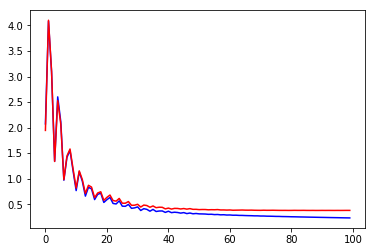

In [44]:
sess = tf.Session()
# variable 초기화
sess.run(tf.global_variables_initializer())    
# traing 시킬 데이터 수
num_examples = len(X_train)

print("Training ..")
print()

for i in range(EPOCHS):
    # train 데이터를 shuffling 후 사용 (여기서는 사용 안함 --> try 해 볼 것)
    x_train_sh, y_train_sh = X_train, y_train

    # batch size 만큼씩 읽어서 training
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = x_train_sh[offset:end], y_train_sh[offset:end]

        # feed training data and run
        sess.run([training_op],feed_dict={x_placeholder:batch_x, y_placeholder:batch_y,prob:1.0})
        
    # 검증용 test data loss 측정 (EPOCH 단위로)
    valid_loss = evaluate(X_test, y_test,sess)
    # train data loss 측정 (EPOCH 단위로)
    train_loss = evaluate(x_train_sh, y_train_sh,sess)
    
    # for graph
    list_train_loss.append(train_loss)
    list_valid_loss.append(valid_loss)

    print('\r',"EPOCH {} ...".format(i+1),
          "Validation Loss = {:.3f} ...".format(valid_loss),
          "Training Loss = {0:.3f} ...".format(train_loss),end='')
    
    if len(epochs) == 0:
        epochs.append(0)
    else:
        epochs.append(epochs[-1]+1)
    
#plotting Accuracy graph
plt.plot(epochs,list_train_loss,'b-',epochs,list_valid_loss,'r-')
plt.show()

### Predict

In [45]:
pred = hypothesis
# train 할 때와 마찬가지로 예측 할 feature 값들의 scale 을 조정
predicted_labels = sess.run(pred, feed_dict={x_placeholder: StandardScaler().fit_transform(X_submit),prob: 1.0})

# 예측은 log(x+1) 기준으로 학습한 결과값이기 때문에 원래 값으로 원복해야 함
predicted_labels = np.exp(predicted_labels)-1
predicted_labels

array([  13.10957909,    4.79337168,    2.68284369, ...,  125.22452545,
         85.47080994,   35.78455353], dtype=float32)

## For Kaggle

In [46]:
# kaggle 제출용 데이터 생성
submission = pd.read_csv("data/sampleSubmission.csv")
submission["count"] = predicted_labels
print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,13.109579
1,2011-01-20 01:00:00,4.793372
2,2011-01-20 02:00:00,2.682844
3,2011-01-20 03:00:00,2.480009
4,2011-01-20 04:00:00,2.541096


In [32]:
# 저장할 파일을 구분하기 위해 파일명에 timestamp 정보 추가 하기 위한 작업 
from datetime import datetime

current_date = datetime.now()
current_date = current_date.strftime("%Y-%m-%d_%H-%M-%S")

description = "bike-tensorflow-layers"

filename = "{date}_{desc}.csv".format(date=current_date, desc=description)
filepath = "data/{filename}".format(filename=filename)

submission.to_csv(filepath, index=False)